In [66]:
import pandas as pd
import warnings
import sqlite3
import seaborn as sns
import re
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split

we are selecting score>3 consider as positive,score<3 consider as negative and ignoring score=3

In [70]:
con = sqlite3.connect('database.sqlite') 
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 
def partition(x):
    if x < 3:
        return 0
    return 1
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [71]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [72]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


in above table ,clearly visible that there are many duplicate values so now we keep only first value and delete all other duplicate values

In [73]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [74]:
display['COUNT(*)'].sum()

393063

In [75]:
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [76]:
final=sorted_data.drop_duplicates(subset={'UserId','ProfileName','Time','Text'},keep='first',inplace=False)
final.shape

(364173, 10)

In [77]:
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [78]:
final.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."


In [79]:
d=pd.DataFrame(final[final['HelpfulnessNumerator']>final['HelpfulnessDenominator']])

In [80]:
d

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
59301,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,1,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
41159,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,1,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


Observation:- It is also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [81]:
final=final.drop(index=[64422,44737])

In [82]:
print(final.shape)
print(final["Score"].value_counts())

(364171, 10)
1    307061
0     57110
Name: Score, dtype: int64


<AxesSubplot:xlabel='Score', ylabel='count'>

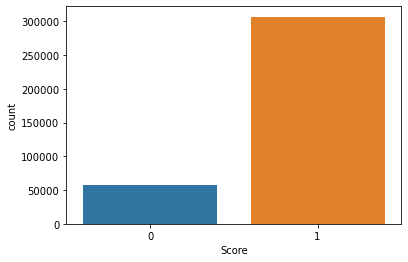

In [83]:
sns.countplot(data=final,x=final['Score'])

in above plot here clearly seen that data is highly imbalanced

checking data contains any null values or not

In [84]:
final.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

# Preprocessing of data 
1.removing html tags <br>
2.removing links<br>
3.all text converted into lowercase characters<br>
4.the word  which have lenght less than 2 are removing<br>
5.removing punctuation marks like . or , or # <br>
6.checking the word is made up of word letters not from alpha numeric<br>
7.removing stopwords<br>
8.stemming

In [85]:
text_0=final['Text'].values[0]
print(text_0)
print("*"*120)
text_400=final['Text'].values[4]
text_1000=final['Text'].values[1000]
print(text_400)
print(120*"*")
print(text_1000)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
************************************************************************************************************************
This is a book of poetry about the months of the year.  It goes through each month and has a cute little poem to go along with it.  I love this book because it is a really fun way to learn the months and the poems are very creative. The author's purpose for writing this book was to give children a fun way to learn the months.  The children can also learn things about poetry and rhythm through reading this book.
****************************************************************************************

In [86]:
df_text=final['Text']
df_text.shape

(364171,)

In [87]:
def decontracted(phrase):
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [88]:
from tqdm import tqdm
preprocessed_reviews = []
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [02:11<00:00, 2768.16it/s]


In [89]:
preprocessed_reviews[0]

'witty little book makes son laugh loud recite car driving along always sing refrain learned whales india drooping roses love new words book introduces silliness classic book willing bet son still able recite memory college'

In [90]:
final['clean text']=preprocessed_reviews
final=final[['Time','clean text','Score']]
final=final.reset_index(drop=True)
final.to_csv('preprocessed_file.csv',index=False)

In [91]:
final=pd.read_csv('preprocessed_file.csv')
final.head()

,Time,clean text,Score
0,939340800,witty little book makes son laugh loud recite ...,1
1,1194739200,grew reading sendak books watching really rosi...,1
2,1191456000,fun way children learn months year learn poems...,1
3,1076025600,great little book read aloud nice rhythm well ...,1
4,1018396800,book poetry months year goes month cute little...,1


data is changing over time,so here time based splitting is used. 

In [92]:
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364171 entries, 0 to 364170
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Time        364171 non-null  int64 
 1   clean text  363192 non-null  object
 2   Score       364171 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 8.3+ MB


In [93]:
final.isnull().all()

Time          False
clean text    False
Score         False
dtype: bool

In [94]:
final['Time']=pd.to_datetime(final['Time'],unit='s')
final=final.sort_values('Time')
final=final.reset_index(drop=True)

In [95]:
final.head()

,Time,clean text,Score
0,1999-10-08,witty little book makes son laugh loud recite ...,1
1,1999-10-25,remember seeing show aired television years ag...,1
2,1999-12-02,beetlejuice well written movie everything exce...,1
3,1999-12-06,twist rumplestiskin captured film starring mic...,1
4,2000-01-03,beetlejuice excellent funny movie keaton hilar...,1


In [96]:
final=final.sample(10000,random_state=42)

splitting the data into train and test part

In [98]:
x=final["clean text"]
y=final["Score"]
x_train,x_test,y_train,y_test=train_test_split(x,y,stratify=y,test_size=0.3,random_state=42)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(7000,) (7000,)
(3000,) (3000,)
